In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib import rc
plt.style.use('classic')
rc('font', **{'family': 'DejaVu Sans', 'serif': ['Computer Modern'], 'size':15})
rc('figure', facecolor='w')
import astropy.io.fits as fits
from astropy.nddata import Cutout2D
import math, os
from scipy.stats import poisson
from legacy import plotImg

#optional dependencies
from distutils.spawn import find_executable

if find_executable('latex'): rc('text', usetex=True)
else: rc('text', usetex=False)
    
try: from natsort import natsorted
except: pass

In [2]:
def mean(array):
    return np.sum(array)/len(array)

def stdev(array):
    return np.sqrt(sum((array - mean(array))**2)/(len(array) - 1))

In [3]:
def poisson_approx(data, mean):
    pdist = np.array(np.exp((data*np.log(mean))-(data*np.log(data))+data-mean))
    return pdist

def gaussian(data,mean,sigma):
    gdist = np.array((1/(sigma*(2*math.pi)**(.5)))*np.exp(-.5*((data-mean)/sigma)**2))   
    return gdist

/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in log
  
/home/jess/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in multiply
  


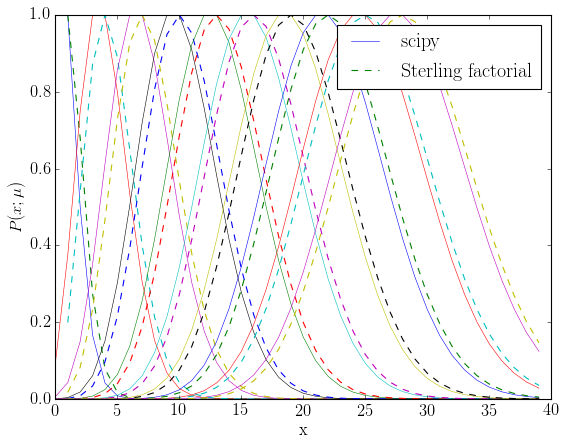

In [4]:
x = np.arange(0,40,1)
for mu in range(1,30,3): 
    pdist1 = poisson.pmf(x, mu)
    pdist1 = pdist1/max(pdist1)
    pdist2 = poisson_approx(x, mu)
    
    if mu == 1:
        plt.plot(x, pdist1, linewidth=.5, label='scipy')
        plt.plot(x, pdist2, linestyle='dashed', label='Sterling factorial')
    else:
        plt.plot(x, pdist1, linewidth=.5)
        plt.plot(x, pdist2, linestyle='dashed')
plt.legend(loc='upper right')
plt.xlabel('x')
plt.ylabel(r'$P(x;\mu)$')
plt.savefig('writeup/plots/poisson_comparisons.png')
plt.show()

In [5]:
def readData(folder):
    """
    Read all frames from a given directory into one matrix.
    input:  directory to folder containing frames
    output: array3d (dimension: xpixel x ypixel x # frames)
            array2D (dimension: 1D flattened img x # frames)
    """
    
    files = os.listdir(folder)

    array3D, array2D = [], []
    for ff in files:
        arr = fits.getdata(folder + ff)
        array3D.append(arr)
        array2D.append(arr.flatten())
    
    return np.array(array3D)

def combineFrame(data_array):
    """
    Combine image frames and return 1D array.
    input:  data array (dimension: # 1D detector counts x # frames)
    output: 1D combined array of detector counts (ADU)
    """
    
    return np.median(data_array, axis=0)

In [14]:
def plotImg(arr, **kwargs):
    
    avg = mean(arr.flatten())
    std = stdev(arr.flatten())
    
    fig,ax = plt.subplots(1)
    pl = plt.imshow(arr, origin='lower', interpolation='nearest', cmap='gray', \
                    vmin=np.percentile(arr, 10), vmax=np.percentile(arr, 90))
    if 'window' in kwargs:
        window = kwargs.get('window')
        rect = patches.Rectangle(window[0], window[1][1], window[1][0], edgecolor='r', facecolor='none')
        ax.add_patch(rect)
    plt.colorbar().set_label('Detector Value (ADU)')
    plt.xlabel('pixels(x)')
    plt.ylabel('pixels(y)')
    if 'save_dir' in kwargs:
        save_dir = kwargs.get('save_dir')
        plt.savefig(save_dir + 'selection_window.png')
    plt.show()

def plotAll(array2D, **kwargs):
    """
    Input:  'array2D': 2D image array
    Output: show plot of histogram and image
    """
    
    arr = array2D.flatten()
    
    avg = mean(arr)
    std = stdev(arr)
    med = np.median(arr)
    Npix = len(arr)    
    
    sigma = kwargs.get('sigma', 2)
    low = int(np.round((avg-sigma*std)))
    high = int(np.round((avg+sigma*std)))
    rng = kwargs.get('rng', [low, high])
    exp = kwargs.get('exp')
    if 'nbins' in kwargs:
        nbins = kwargs.get('nbins')
        bin_size = (rng[1]-rng[0])/nbins
    else:
        bin_size = kwargs.get('bin_size', 1)
    
    fig, (ax1, ax2) = plt.subplots(1,2, figsize=[18,6])
    
    # Histogram
    #===========
    hr = np.arange(rng[0], rng[1]+1, bin_size)
    hist = []
    for i in range(len(hr)):
        try:
            counts = len(np.where((arr >= hr[i]) & (arr < hr[i+1]))[0])
        except:
            counts = 0
        hist.append(counts)
    ax1.step(hr, hist, color='k')

    #mean and median lines
    ax1.axvline(avg, color='b', label=r'$\bar{x}=%s$'%(np.round(avg,2)))
#     ax1.axvline(med, color='b', label=r'$\tilde{x}=%s$'%(np.round(med,2)), linestyle='dashed')
    
    #sigma levels
    if kwargs.get('show_level', True) == True:
        for i in np.arange(1,sigma+1):
            if i == 1:
                ax1.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05, label=r'$s=\pm %s$'%(np.round(std,2)))
            else:
                ax1.axvspan(avg-i*std, avg+i*std, facecolor='g', alpha=0.05)
                
                
    #poisson distribution
    xarray = np.arange(rng[0]-10, rng[1]+10, 1)
    pdist = poisson_approx(xarray, avg)
    pdist = max(hist)/max(pdist)*pdist
    ax1.plot(xarray, pdist, color='r', label=r'$P_{Poisson}(\bar{x})$')
    std_expected = math.sqrt(avg)
    ax1.axvspan(avg - std_expected, avg + std_expected, facecolor='r', alpha=0.05, \
                label=r'$\sigma=\pm %s$'%(np.round(std_expected,2)))
    
    #gaussian distribution
    gdist = gaussian(xarray, avg, std)
    gdist = max(hist)/max(gdist)*gdist
    ax1.plot(xarray, gdist, color='c', label=r'$P_{Gaussian}(\bar{x}, s)$')
    
    ax1.legend(loc='upper left')
    ax1.set_xlabel('Counts (ADU)')
    ax1.set_ylabel('Frequency')
    
    if 'exp' in kwargs:
        ax1.set_title('Combined Histogram (Exposure Time: %s sec)'%(exp))
    ax1.set_xlim(rng)
    
    # Image
    #===========
    hrng = kwargs.get('hrng', [np.percentile(arr, 10), np.percentile(arr, 90)])
    pl = ax2.imshow(array2D, origin='lower', interpolation='nearest', cmap='gray', vmin=hrng[0], vmax=hrng[1])
    fig.colorbar(pl, ax=ax2, fraction=0.046, pad=0.04).set_label('Detector Value (ADU)')
    
    ax2.set_xlabel('pixels(x)')
    ax2.set_ylabel('pixels(y)')
    ax2.set_title('Combined Image')
    
    if 'save_dir' in kwargs:
        save_dir = kwargs.get('save_dir')
        plt.savefig(save_dir + 'exposure%s.png'%(exp))
    plt.show()

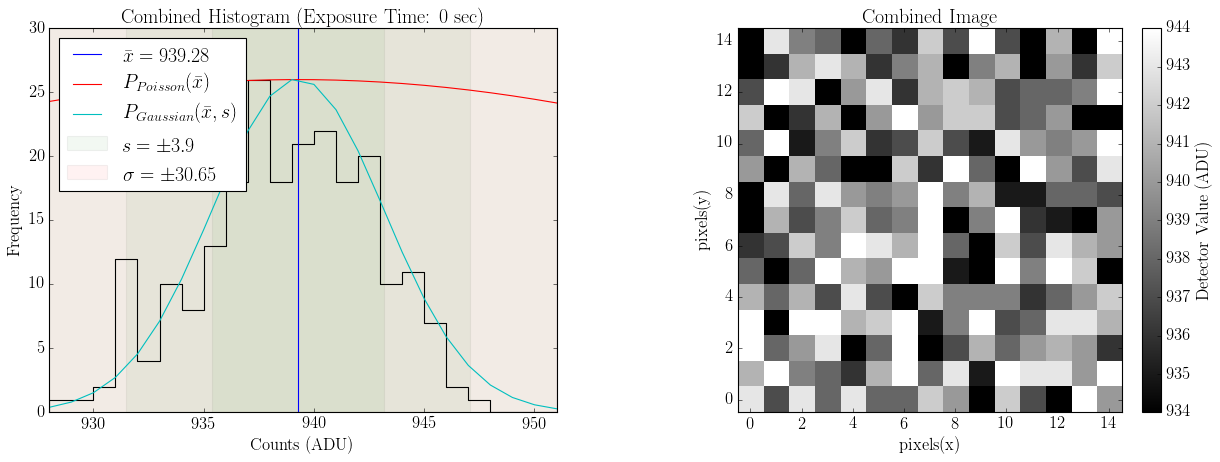

In [17]:
window = [(550,550), (15,15)]

bias_3D = readData('data/exp0/')
bias_2D = combineFrame(bias_3D)

#cut data
bias_2D_cut = Cutout2D(bias_2D, window[0], window[1]).data

plotAll(bias_2D_cut, sigma=3, exp=0, save_dir='writeup/plots/')

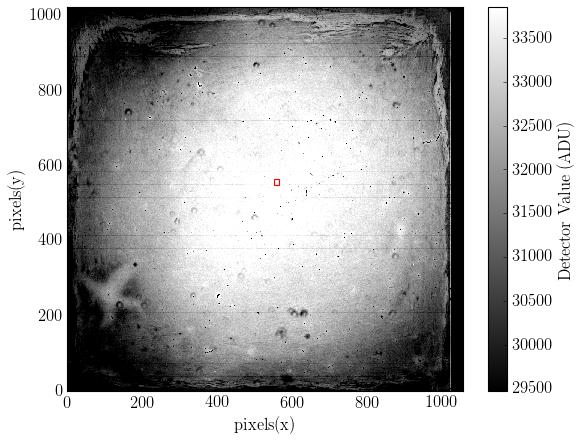

In [18]:
#check if image slice looks good on long exposure image
longexp_3D = readData('data/exp768/')
longexp_sub_3D = [(frame - bias_2D) for frame in longexp_3D]
longexp_2D = combineFrame(longexp_sub_3D)

plotImg(longexp_2D, window=window, save_dir='writeup/plots/')

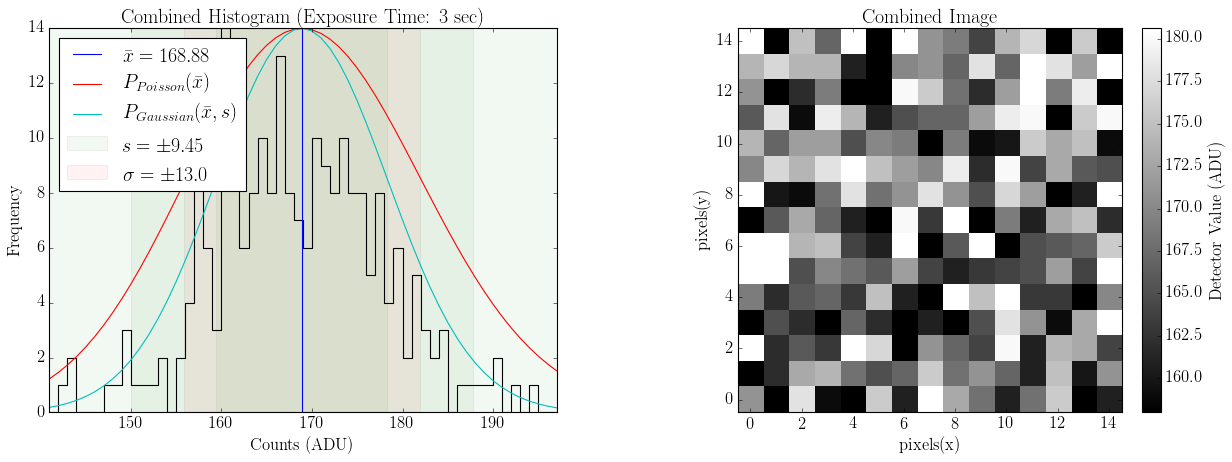

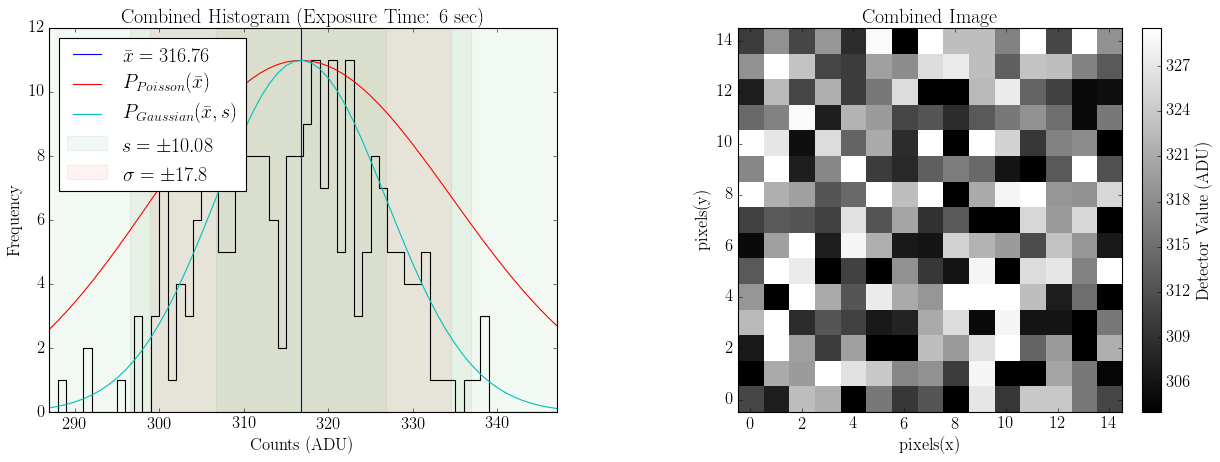

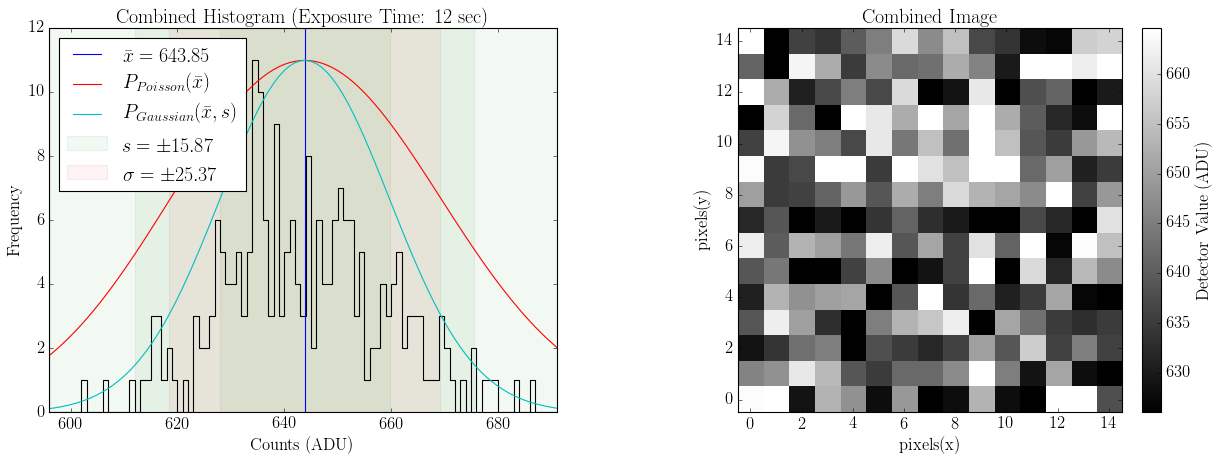

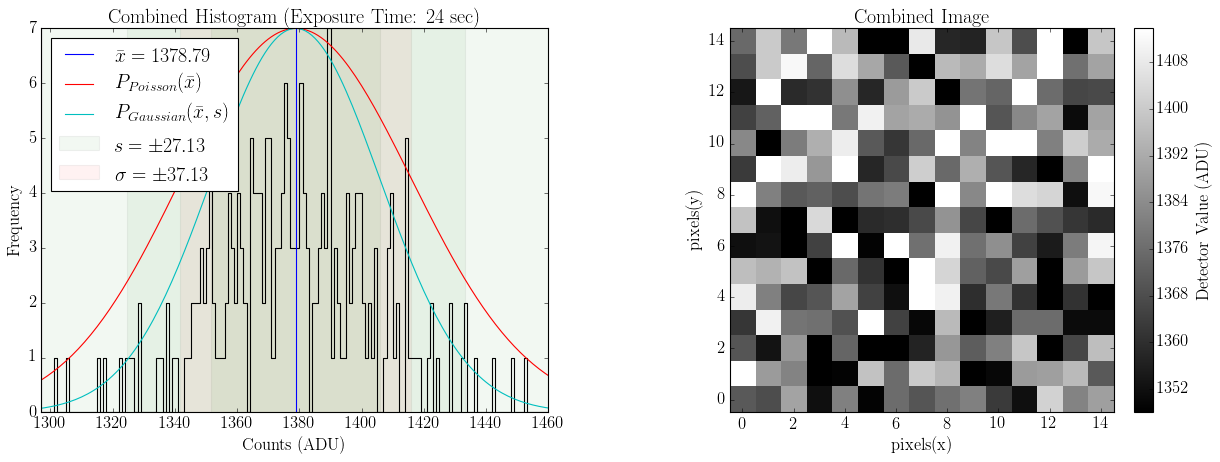

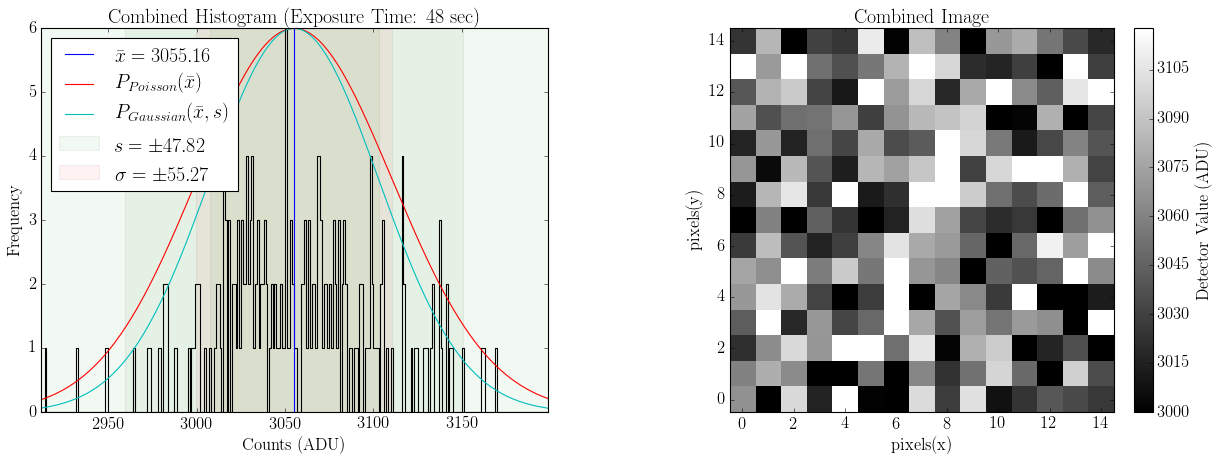

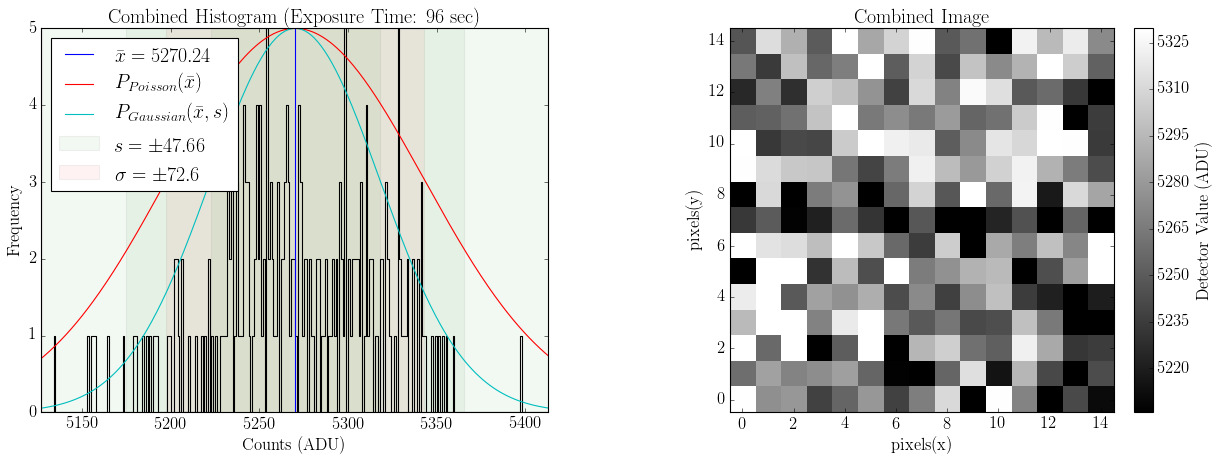

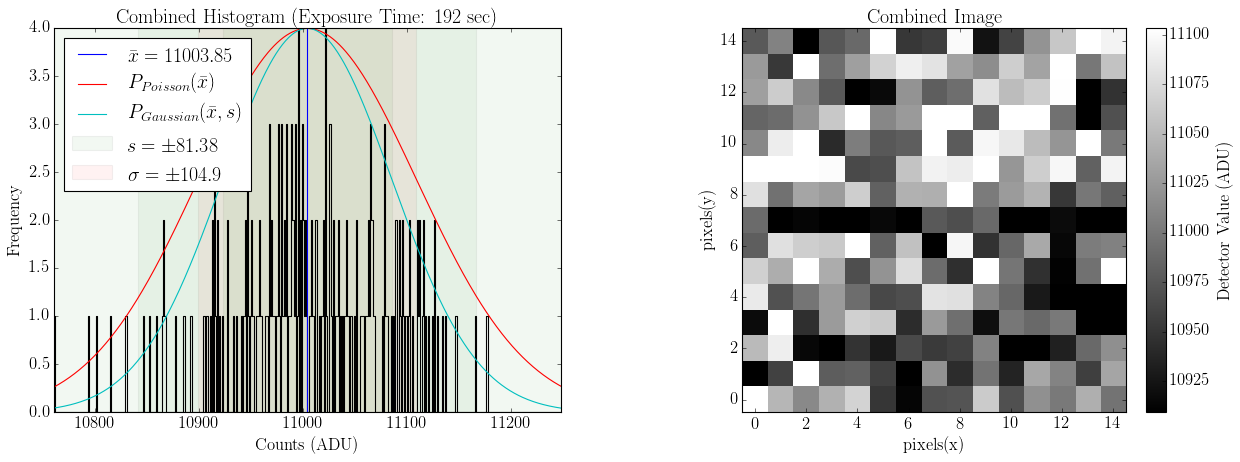

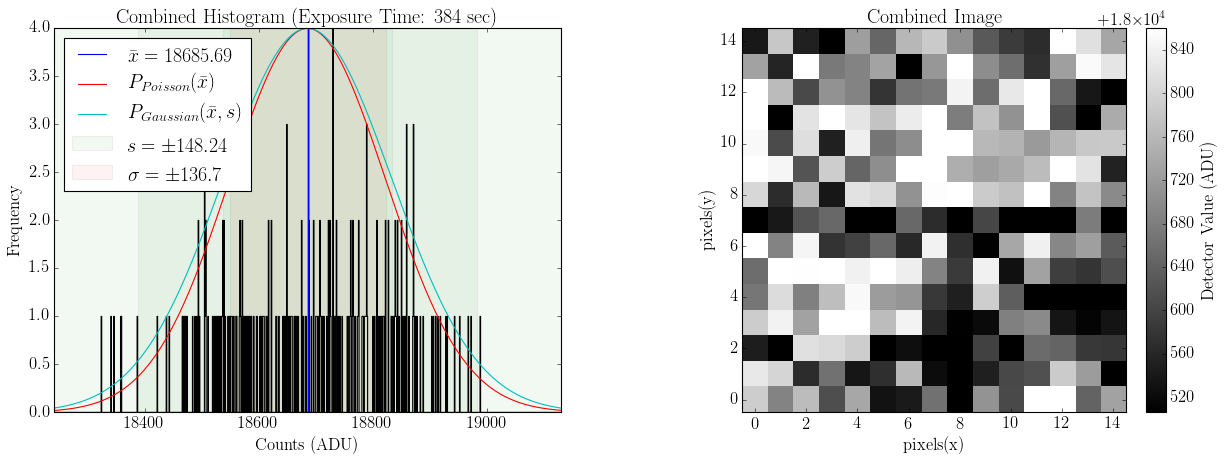

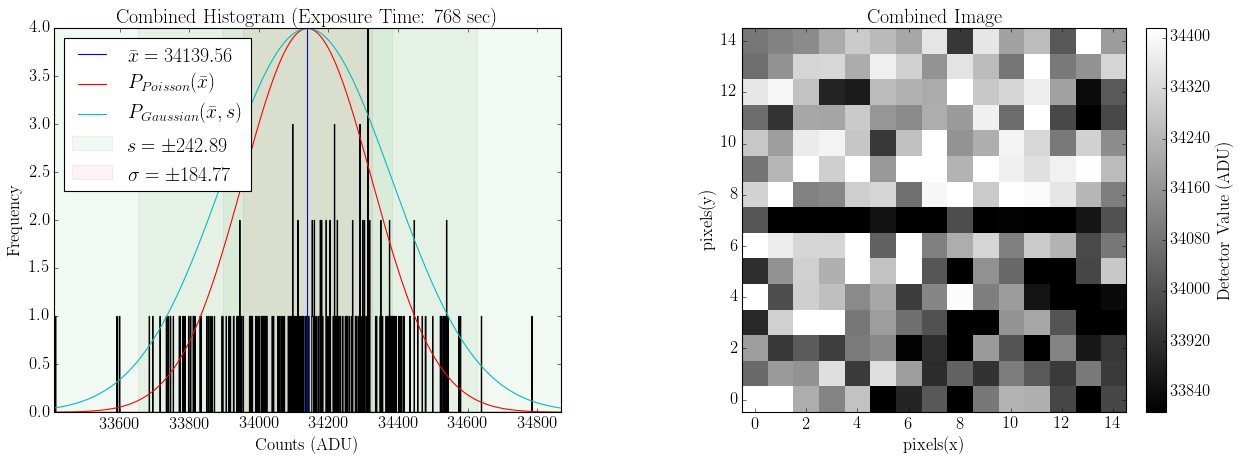

In [19]:
try:
    files = natsorted(os.listdir('data/'))[1:]
except:
    files = os.listdir('data/')
exp_times = np.array([int(f.split('exp')[1]) for f in files])

#combined frames, and combined frames in counts per second
counts, counts_ps = [], []
for exp in exp_times:
    
    #Read frames, subtract combined bias, combine frames
    array3D = readData('data/exp%s/'%(exp))
    bias_sub_3D = [(frame - bias_2D) for frame in array3D]
    array2D = combineFrame(bias_sub_3D)
    
    array2D_cps = array2D/exp
    
    #cut out safe part of image
    cut = Cutout2D(array2D, window[0], window[1]).data
    cut_cps = Cutout2D(array2D_cps, window[0], window[1]).data
    
    counts.append(cut.flatten())
    counts_ps.append(cut_cps.flatten())
    
    #Plot histogram and image & save to .png
    plotAll(cut, sigma=3, exp=exp, show_level=True, save_dir='writeup/plots/')

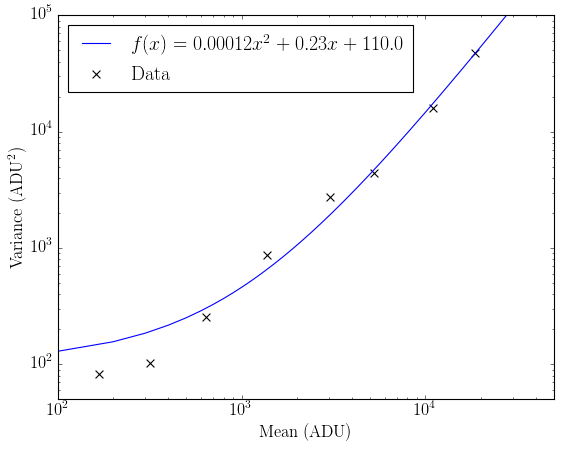

In [172]:
xbar = np.mean(counts, axis=1)
s = np.std(counts, axis=1)

#fit polynomial
x_arr = np.arange(0, 10**5, 10**2)
fit = np.polyfit(xbar, s**2, 2)
y_arr = np.polyval(fit, x_arr)

#plot data
plt.scatter(xbar, s**2, marker='x', s=50, color='k', label='Data')
#plot 2nd degree polynomial
coeff = [np.round(f,1-int(math.floor(math.log10(abs(f))))) for f in fit]
plt.plot(x_arr, y_arr, label=r'$f(x)=%s x^2 + %s x + %s$'%(coeff[0], coeff[1], coeff[2]))

plt.xlim(100, 5*10**4)
plt.ylim(50, 10**5)
plt.xscale('log')
plt.yscale('log')
plt.xlabel('Mean (ADU)')
plt.ylabel('Variance (ADU$^2$)')
plt.legend(loc='upper left', scatterpoints=1)
plt.savefig('writeup/plots/mean_vs_variance.png')
plt.show()

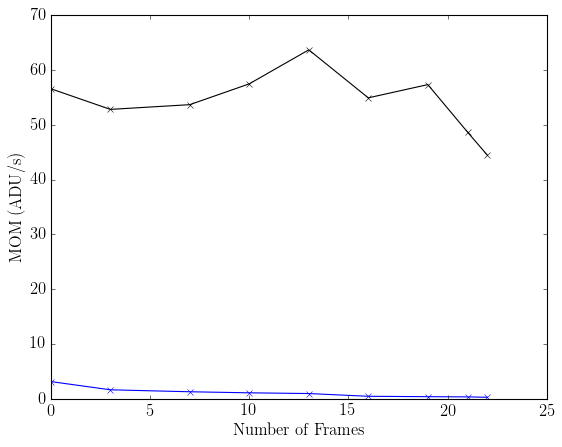

In [106]:
#counts per second
xbar_cps = np.mean(counts_ps, axis=1)
s_cps = np.std(counts_ps, axis=1)

#number of frames per exposure
num_per_dir = [len(os.listdir('data/'+f)) for f in files]
nframes = [sum(num_per_dir[0:i]) for i in range(len(files))]

plt.plot(nframes, xbar_cps, marker='x', color='k')
plt.plot(nframes, s_cps, marker='x', color='b')
plt.xlabel('Number of Frames')
plt.ylabel('MOM (ADU/s)')
plt.savefig('writeup/plots/exptime_vs_meancount.png')
plt.show()


#





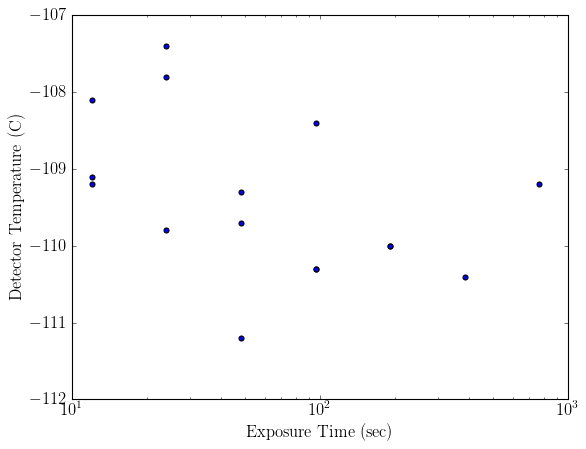

In [111]:
etime, temp = [], []
for exp in os.listdir('data/'):
    fdir = 'data/%s/'%(exp)
    for file in os.listdir(fdir):
        hdr = fits.open(fdir + file)
        data = np.array(hdr[0].data).flatten()
        etime.append(hdr[0].header['EXPTIME'])
        temp.append(hdr[0].header['TEMPDET'])
        
plt.scatter(etime, temp)
plt.xscale('log')
plt.xlabel('Exposure Time (sec)')
plt.ylabel('Detector Temperature (C)')
plt.xlim(10,1000)
plt.savefig('writeup/plots/exposure_temp.png')
plt.show()

In [ ]:
# Creating MOM and SDOM

# Pulls all the files together
# assums all the frames are in one directory
# Creates an array with all the file names
files = np.array(natsorted(os.listdir()))


data = []

# Go through each frame, take the median, subtract bias, and divide 
# by exposure time
for i in files:

    # loading in the data
    frame_data = fits.getdata(i)
    frame_exp = fits.open(i)
    exp_time = frame_exp[0].header['EXPTIME']
    # Subtracting the bias
    data_subbed = frame_data - bias_2D
    data_median_ps = np.median(data_subbed,axis=0)/exp_time
    # Median of each frame divided by exposure time for that frame
    data.append(data_median_ps)
   
data = np.array(data)

# Setting up arrays 
mom = []
std = []
num_frame = np.arange(2,len(data)+1)

# Calculates MOM and SDOM 
i = 2
while i < len(data)+1:
    frames = data[:i]
    mean = np.mean(frames) 
    stand = np.std(frames)
    mom.append(mean)
    std.append(stand)
    i = i + 1
    
mom = np.array(mom)
std = np.array(std)

plt.scatter(num_frame,mom,marker='x',color='black',label='MOM')
plt.scatter(num_frame,std,marker='v',color='gray',label='SDOM')
plt.xlabel('Number of Frames')
plt.ylabel('Counts/second (ADU/sec)')
plt.legend(loc='best')
plt.savefig('../plots/mom_sdom.png')
plt.show()

